In [1]:
# --- Célula 1: Importações ---
import pandas as pd
import numpy as np
import joblib
import os
import sys
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2025-10-15 23:48:43.460106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-15 23:48:43.477329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-15 23:48:43.482485: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-15 23:48:43.495604: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 23:48:44.224743: W tensorflow/compiler/tf2

In [2]:
# --- Célula 2: Painel de Controle, Definição de Features e Preparação dos Dados ---

# --- DEFINIÇÃO COMPLETA DOS GRUPOS DE FEATURES ---
features_geracao = ['geracao_total_diaria_go', 'geracao_fotovoltaica_diaria', 'geracao_hidroelétrica_diaria', 'geracao_térmica_diaria']
features_rede = ['total_mwh_restrito_go', 'saldo_intercambio_seco', 'restricao_razao_rel', 'restricao_razao_cnf', 'restricao_razao_ene', 'restricao_razao_par', 'restricao_origem_loc', 'restricao_origem_sis']
features_hidrica = ['ear_percentual_seco', 'ena_percentual_mlt_seco']
features_adicionais = ['cmo_semanal_seco', 'disponibilidade_total_diaria_go', 'indicador_ccal_mensal']
features_clima = ['ghi', 'temp2m_c', 'precipitacao_mm']
features_avancadas = ['carga_media_7d','carga_std_7d','geracao_media_7d','ear_ontem','ear_diff_3d','margem_oferta_demanda','pressao_demanda_ear','precip_acumulada_14d','precip_acumulada_30d']
features_calendario = ['mes','dia_da_semana','dia_do_ano']

# --- ESCOLHA O CENÁRIO PARA TESTAR ---
# Opções: 'pos_2022', 'pos_2020', 'pos_2017', 'pos_2015', 'pos_2013', 'pos_2010'
CENARIO_ESCOLHIDO = 'pos_2015' 
# -------------------------------------

# Define o período e as features com base no cenário
if CENARIO_ESCOLHIDO == 'pos_2022':
    START_YEAR = 2022
    nome_cenario = "Ensemble Pós-2022 (Features de Geração)"
    features_para_teste_nomes = (features_geracao + features_rede + features_hidrica + features_adicionais + features_clima + features_calendario + features_avancadas + ['programada'])
elif CENARIO_ESCOLHIDO == 'pos_2020':
    START_YEAR = 2020
    nome_cenario = "Ensemble Pós-2020 (Histórico com Carga Prog.)"
    features_para_teste_nomes = (features_hidrica + features_adicionais + features_clima + features_calendario + features_avancadas + ['programada'])
elif CENARIO_ESCOLHIDO == 'pos_2017':
    START_YEAR = 2017
    nome_cenario = "Ensemble Pós-2017 (Histórico Intermediário)"
    features_para_teste_nomes = (features_hidrica + features_adicionais + features_clima + features_calendario + features_avancadas)
elif CENARIO_ESCOLHIDO == 'pos_2015':
    START_YEAR = 2015
    nome_cenario = "Ensemble Pós-2015 (Histórico com Disponibilidade)"
    features_para_teste_nomes = (features_hidrica + features_adicionais + features_clima + features_calendario + features_avancadas)
elif CENARIO_ESCOLHIDO == 'pos_2013':
    START_YEAR = 2013
    nome_cenario = "Ensemble Pós-2013 (Histórico Extendido Básico)"
    features_para_teste_nomes = (features_hidrica + features_clima + features_calendario + features_avancadas + ['cmo_semanal_seco', 'indicador_ccal_mensal'])
elif CENARIO_ESCOLHIDO == 'pos_2010':
    START_YEAR = 2010
    nome_cenario = "Ensemble Pós-2010 (Máximo Histórico Básico)"
    features_para_teste_nomes = (features_hidrica + features_clima + features_calendario + features_avancadas + ['cmo_semanal_seco', 'indicador_ccal_mensal'])
else:
    raise ValueError("Cenário escolhido é inválido ou não possui modelos treinados.")

print(f"--- INICIANDO EXPERIMENTO COM O CENÁRIO: '{nome_cenario}' ---")

# --- CARREGAMENTO, FILTRAGEM E PREPARAÇÃO DOS DADOS ---
path_final_table = '../data/processed/modeling_table_final.parquet'
df_completo = pd.read_parquet(path_final_table)

sys.path.append('..')
from config import END_YEAR

anos_de_interesse = range(START_YEAR, END_YEAR + 1)
df = df_completo[df_completo.index.year.isin(anos_de_interesse)].copy()

features_para_teste = [col for col in features_para_teste_nomes if col in df.columns]
X = df[features_para_teste]
y = df['nivel_risco']

mapeamento_risco = {'baixo': 0, 'medio': 1, 'alto': 2}
y_encoded = y.map(mapeamento_risco)

# Split temporal (consistente com o treino do LSTM)
test_size = 0.2
split_index = int(len(X) * (1 - test_size))
X_test = X[split_index:]
y_test = y_encoded[split_index:]

print(f"Dados de teste preparados: {X_test.shape[0]} amostras para o período de {X_test.index.min().date()} a {X_test.index.max().date()}.")

--- INICIANDO EXPERIMENTO COM O CENÁRIO: 'Ensemble Pós-2015 (Histórico com Disponibilidade)' ---
Dados de teste preparados: 782 amostras para o período de 2023-07-23 a 2025-09-11.


In [3]:
# --- Célula 3: Carregamento Dinâmico dos Modelos e Scalers ---
MODEL_DIR = '../models/'

# Extrai o ano do nome do cenário para carregar os arquivos corretos
year_str = CENARIO_ESCOLHIDO.split('_')[1]

# Nomes de arquivo dinâmicos
# Assumindo que os modelos LSTM também seguem o padrão 'pos_ANO'
lstm_model_path = os.path.join(MODEL_DIR, f'best_lstm_model_{CENARIO_ESCOLHIDO}.h5')
lstm_scaler_path = os.path.join(MODEL_DIR, f'scaler_lstm_{CENARIO_ESCOLHIDO}.joblib')
xgb_model_path = os.path.join(MODEL_DIR, f'best_xgboost_model_{year_str}.joblib')
xgb_scaler_path = os.path.join(MODEL_DIR, f'scaler_xgb_{year_str}.joblib')
brf_model_path = os.path.join(MODEL_DIR, f'best_brf_model_{year_str}.joblib')
brf_scaler_path = os.path.join(MODEL_DIR, f'scaler_brf_{year_str}.joblib')

# Carregar os modelos e scalers
print(f"Carregando artefatos para o cenário: {CENARIO_ESCOLHIDO}")
model_lstm = load_model(lstm_model_path)
scaler_lstm = joblib.load(lstm_scaler_path)
model_xgb = joblib.load(xgb_model_path)
scaler_xgb = joblib.load(xgb_scaler_path)
model_brf = joblib.load(brf_model_path)
scaler_brf = joblib.load(brf_scaler_path)

print("\nModelos e scalers carregados com sucesso!")

Carregando artefatos para o cenário: pos_2015


I0000 00:00:1760582925.565702  599488 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1760582925.611796  599488 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1760582925.614165  599488 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1760582925.618614  599488 cuda_executor.cc:1015] successful NUMA node read from SysFS ha


Modelos e scalers carregados com sucesso!


In [4]:
# --- Célula 4: Gerar Previsões de Cada Modelo ---

# 1. Previsão do LSTM (requer dados em sequência)
# --------------------------------------------------
TIME_STEPS = 14

# Função para criar sequências, igual à do notebook de treino
def create_sequences(X_data, y_data, time_steps=14):
    Xs, ys = [], []
    for i in range(len(X_data) - time_steps):
        Xs.append(X_data[i:(i + time_steps)])
        ys.append(y_data[i + time_steps])
    return np.array(Xs), np.array(ys)

# Normaliza os dados de teste com o scaler do LSTM
X_test_scaled_lstm = scaler_lstm.transform(X_test)

# Cria as sequências e o y_test correspondente
X_test_seq, y_test_seq = create_sequences(X_test_scaled_lstm, y_test.values, TIME_STEPS)

# Gera as probabilidades
y_pred_proba_lstm = model_lstm.predict(X_test_seq)

print(f"Previsões LSTM geradas. Formato: {y_pred_proba_lstm.shape}")
print(f"Labels de teste alinhados (y_test_seq). Formato: {y_test_seq.shape}")

# 2. Previsões do XGBoost e BalancedRandomForest (dados tabulares)
# ------------------------------------------------------------------

# Precisamos usar os dados de teste a partir do 15º dia para alinhar com o LSTM
X_test_flat_aligned = X_test.iloc[TIME_STEPS:]

# Normaliza com os respectivos scalers
X_test_scaled_xgb = scaler_xgb.transform(X_test_flat_aligned)
X_test_scaled_brf = scaler_brf.transform(X_test_flat_aligned)

# Gera as probabilidades
y_pred_proba_xgb = model_xgb.predict_proba(X_test_scaled_xgb)
y_pred_proba_brf = model_brf.predict_proba(X_test_scaled_brf)

print(f"Previsões XGBoost geradas. Formato: {y_pred_proba_xgb.shape}")
print(f"Previsões BalancedRF geradas. Formato: {y_pred_proba_brf.shape}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2025-10-15 23:48:47.561326: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Previsões LSTM geradas. Formato: (768, 3)
Labels de teste alinhados (y_test_seq). Formato: (768,)
Previsões XGBoost geradas. Formato: (768, 3)
Previsões BalancedRF geradas. Formato: (768, 3)



--- Resultados Finais do Modelo Ensemble ---
              precision    recall  f1-score   support

       baixo       0.99      0.98      0.98       741
       medio       0.80      0.80      0.80        15
        alto       0.35      0.50      0.41        12

    accuracy                           0.97       768
   macro avg       0.71      0.76      0.73       768
weighted avg       0.97      0.97      0.97       768



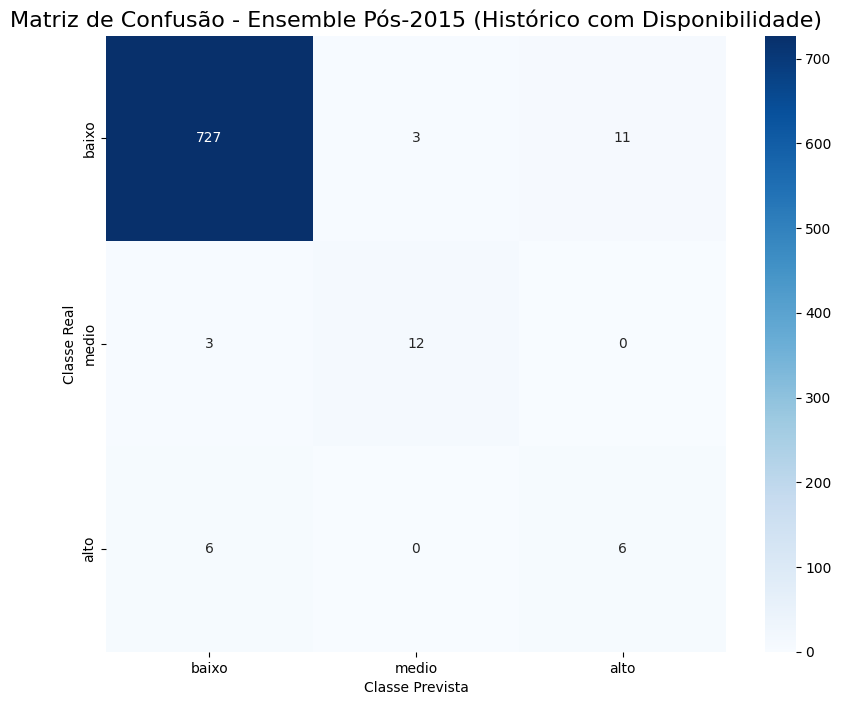

In [5]:
# --- Célula 5: Ensemble por Média e Avaliação Final ---

# Média simples das probabilidades
y_pred_proba_ensemble = (y_pred_proba_lstm + y_pred_proba_xgb + y_pred_proba_brf) / 3.0

# A previsão final é a classe com a maior probabilidade média
y_pred_ensemble = np.argmax(y_pred_proba_ensemble, axis=1)

print(f"\n--- Resultados Finais do Modelo Ensemble ---")
print(classification_report(
    y_test_seq, 
    y_pred_ensemble, 
    target_names=mapeamento_risco.keys(), 
    zero_division=0
))

# Matriz de Confusão para o Ensemble
cm_ensemble = confusion_matrix(y_test_seq, y_pred_ensemble)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_ensemble, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=mapeamento_risco.keys(),
    yticklabels=mapeamento_risco.keys()
)
plt.title(f'Matriz de Confusão - {nome_cenario}', fontsize=16)
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()